In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fast_ml==3.68


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from fast_ml.model_development import train_valid_test_split
from transformers import Trainer, TrainingArguments, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
from torch.nn.functional import softmax
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import datasets


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f'Device Availble: {DEVICE}')


Device Availble: cpu


In [3]:
df = pd.read_csv('news_data_all_labeled.csv')
df.head()


,Unnamed: 0,Published Date,Title,AllSides Content,URL,News Channel,News Channel URL,Bias,Tags,topic,News Article Content,Processed text,Title_Sentiment_nltk,Sentiment_Content_nltk,Title_Sentiment_huggingface_a,Title_Sentiment_huggingface_b,Sentiment_Content_huggingface_b
0,0,Feb 21 2024,Reproductive policy fights renew the focus on IVF,An Alabama Supreme Court decision legally reco...,https://www.allsides.com/news/2024-02-21-1315/...,Roll Call,https://rollcall.com/2024/02/20/reproductive-p...,center,"['Supreme Court', 'Healthcare', 'Pregnancy', '...",abortion,An Alabama Supreme Court decision legally reco...,alabama supreme court decision legally recogni...,-0.4019,0.9900,0.865067,0.543246,0.536185
1,1,Mar 24 2024,'Some serious stigma': Arizona lawmaker explai...,Democratic Sen. Eva Burch got call from VP Har...,https://www.allsides.com/news/2024-03-24-1430/...,12News,https://12news.com/article/news/politics/sunda...,center,['Abortion'],abortion,Democratic Sen. Eva Burch got call from VP Har...,democratic sen. eva burch got call vp harris s...,-0.0772,0.9524,0.859620,0.542583,0.520938
2,2,Apr 08 2024,Trump says he’s in favor of letting states dec...,NEW YORK — Former President Donald Trump said ...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,jill colvin | associated press new york — form...,0.4019,0.7886,0.728386,0.544220,0.525326
3,3,Mar 01 2024,CVS and Walgreens Will Begin Selling Abortion ...,The two largest pharmacy chains in the United ...,https://www.allsides.com/news/2024-03-01-1330/...,New York Times (News),https://www.nytimes.com/2024/03/01/health/abor...,left,"['Abortion', 'Abortion Pills', 'Public Health'...",abortion,The two largest pharmacy chains in the United ...,two largest pharmacy chain united state start ...,0.0000,0.9612,0.934649,0.538811,0.518969
4,4,Feb 02 2024,Wyoming Supreme Court Says Pro-Lifers Can't In...,The Wyoming Supreme Court on Friday denied a p...,https://www.allsides.com/news/2024-02-02-1225/...,Cowboy State Daily,https://cowboystatedaily.com/2024/02/02/wyomin...,right,"['Abortion', 'Supreme Court']",abortion,The Wyoming Supreme Court on Friday denied a p...,wyoming supreme court friday denied petition t...,0.4019,0.9217,0.802395,0.537625,0.526178


In [4]:
data = df[["Published Date","Title","URL","News Channel","News Channel URL","Bias","Tags","topic",\
             "News Article Content","Processed text","Sentiment_Content_nltk"]]
data.head(10)

,Published Date,Title,URL,News Channel,News Channel URL,Bias,Tags,topic,News Article Content,Processed text,Sentiment_Content_nltk
0,Feb 21 2024,Reproductive policy fights renew the focus on IVF,https://www.allsides.com/news/2024-02-21-1315/...,Roll Call,https://rollcall.com/2024/02/20/reproductive-p...,center,"['Supreme Court', 'Healthcare', 'Pregnancy', '...",abortion,An Alabama Supreme Court decision legally reco...,alabama supreme court decision legally recogni...,0.9900
1,Mar 24 2024,'Some serious stigma': Arizona lawmaker explai...,https://www.allsides.com/news/2024-03-24-1430/...,12News,https://12news.com/article/news/politics/sunda...,center,['Abortion'],abortion,Democratic Sen. Eva Burch got call from VP Har...,democratic sen. eva burch got call vp harris s...,0.9524
2,Apr 08 2024,Trump says he’s in favor of letting states dec...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,jill colvin | associated press new york — form...,0.7886
3,Mar 01 2024,CVS and Walgreens Will Begin Selling Abortion ...,https://www.allsides.com/news/2024-03-01-1330/...,New York Times (News),https://www.nytimes.com/2024/03/01/health/abor...,left,"['Abortion', 'Abortion Pills', 'Public Health'...",abortion,The two largest pharmacy chains in the United ...,two largest pharmacy chain united state start ...,0.9612
4,Feb 02 2024,Wyoming Supreme Court Says Pro-Lifers Can't In...,https://www.allsides.com/news/2024-02-02-1225/...,Cowboy State Daily,https://cowboystatedaily.com/2024/02/02/wyomin...,right,"['Abortion', 'Supreme Court']",abortion,The Wyoming Supreme Court on Friday denied a p...,wyoming supreme court friday denied petition t...,0.9217
5,Feb 13 2024,"New gun, abortion and labor laws take effect i...",https://www.allsides.com/news/2024-02-13-0322/...,Detroit Free Press,https://freep.com/story/news/politics/2024/02/...,left,['Abortion'],abortion,New Michigan laws approved by Democrats take e...,new michigan law approved democrat take effect...,-0.9689
6,Apr 04 2024,Latest 2024 election news: Harris returning to...,https://www.allsides.com/news/2024-04-04-0430/...,Washington Post,https://washingtonpost.com/elections/2024/04/0...,left,"['2024 Elections', 'Politics']",abortion,Election 2024\n\nGet the latest news on the 20...,election 2024 get latest news 2024 election re...,0.7964
7,Mar 25 2024,New York pro-lifers march with ‘joy on steroids’,https://www.allsides.com/news/2024-03-26-0015/...,Catholic News Agency,https://catholicnewsagency.com/news/257193/pho...,right,['General News'],abortion,The New York Police Department arrested at lea...,new york police department arrested least eigh...,0.8101
8,Apr 08 2024,Trump says he’s in favor of letting states dec...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,jill colvin | associated press new york — form...,0.7886
9,Mar 27 2024,How A Leftist Network Of Websites Floods Red S...,https://www.allsides.com/news/2024-03-27-1548/...,The Daily Wire,https://www.dailywire.com/news/how-leftist-net...,right,"['Abortion', 'Misinformation And Disinformatio...",abortion,"Facilitated by Left-wing activist groups, a ne...","facilitated left-wing activist group , network...",0.9988


In [5]:
data.topic.value_counts()

topic
immigration       2997
abortion          2605
environment       1408
healthcare        1402
sustainability    1325
public-health     1284
Name: count, dtype: int64

In [6]:
topic_mapping = {
    'public-health': 'Public Healthcare',
    'healthcare': 'Public Healthcare',
    'environment':'Environment and Sustainability',
    'sustainability':'Environment and Sustainability',
    'abortion':'Abortion',
    'immigration':"Immigration"
}

# Replace the old topics with the new combined topic
data['topic'] = data['topic'].replace(topic_mapping)


In [7]:
data.topic.value_counts()

topic
Immigration                       2997
Environment and Sustainability    2733
Public Healthcare                 2686
Abortion                          2605
Name: count, dtype: int64

<Axes: ylabel='topic'>

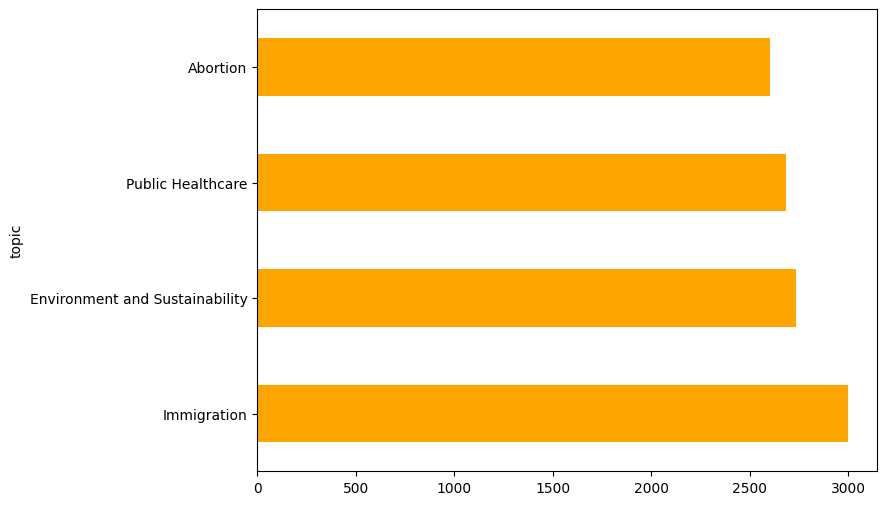

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
data['topic'].value_counts().plot(kind='barh', color='orange')

In [9]:
data = data.rename(columns={'Sentiment_Content_nltk': 'Label'})
data["Label"] = data["Label"].round(1)

In [10]:
data.Label.value_counts()

Label
 1.0    3752
-1.0    2693
 0.9    1023
-0.9     791
 0.8     348
-0.8     307
 0.6     234
-0.7     208
 0.2     196
 0.1     193
-0.4     179
 0.7     157
 0.4     138
-0.6     137
-0.2     130
-0.1     126
 0.5     126
-0.5     111
-0.0      75
-0.3      72
 0.3      25
Name: count, dtype: int64

In [11]:
data.head(10)

,Published Date,Title,URL,News Channel,News Channel URL,Bias,Tags,topic,News Article Content,Processed text,Label
0,Feb 21 2024,Reproductive policy fights renew the focus on IVF,https://www.allsides.com/news/2024-02-21-1315/...,Roll Call,https://rollcall.com/2024/02/20/reproductive-p...,center,"['Supreme Court', 'Healthcare', 'Pregnancy', '...",Abortion,An Alabama Supreme Court decision legally reco...,alabama supreme court decision legally recogni...,1.0
1,Mar 24 2024,'Some serious stigma': Arizona lawmaker explai...,https://www.allsides.com/news/2024-03-24-1430/...,12News,https://12news.com/article/news/politics/sunda...,center,['Abortion'],Abortion,Democratic Sen. Eva Burch got call from VP Har...,democratic sen. eva burch got call vp harris s...,1.0
2,Apr 08 2024,Trump says he’s in favor of letting states dec...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],Abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,jill colvin | associated press new york — form...,0.8
3,Mar 01 2024,CVS and Walgreens Will Begin Selling Abortion ...,https://www.allsides.com/news/2024-03-01-1330/...,New York Times (News),https://www.nytimes.com/2024/03/01/health/abor...,left,"['Abortion', 'Abortion Pills', 'Public Health'...",Abortion,The two largest pharmacy chains in the United ...,two largest pharmacy chain united state start ...,1.0
4,Feb 02 2024,Wyoming Supreme Court Says Pro-Lifers Can't In...,https://www.allsides.com/news/2024-02-02-1225/...,Cowboy State Daily,https://cowboystatedaily.com/2024/02/02/wyomin...,right,"['Abortion', 'Supreme Court']",Abortion,The Wyoming Supreme Court on Friday denied a p...,wyoming supreme court friday denied petition t...,0.9
5,Feb 13 2024,"New gun, abortion and labor laws take effect i...",https://www.allsides.com/news/2024-02-13-0322/...,Detroit Free Press,https://freep.com/story/news/politics/2024/02/...,left,['Abortion'],Abortion,New Michigan laws approved by Democrats take e...,new michigan law approved democrat take effect...,-1.0
6,Apr 04 2024,Latest 2024 election news: Harris returning to...,https://www.allsides.com/news/2024-04-04-0430/...,Washington Post,https://washingtonpost.com/elections/2024/04/0...,left,"['2024 Elections', 'Politics']",Abortion,Election 2024\n\nGet the latest news on the 20...,election 2024 get latest news 2024 election re...,0.8
7,Mar 25 2024,New York pro-lifers march with ‘joy on steroids’,https://www.allsides.com/news/2024-03-26-0015/...,Catholic News Agency,https://catholicnewsagency.com/news/257193/pho...,right,['General News'],Abortion,The New York Police Department arrested at lea...,new york police department arrested least eigh...,0.8
8,Apr 08 2024,Trump says he’s in favor of letting states dec...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],Abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,jill colvin | associated press new york — form...,0.8
9,Mar 27 2024,How A Leftist Network Of Websites Floods Red S...,https://www.allsides.com/news/2024-03-27-1548/...,The Daily Wire,https://www.dailywire.com/news/how-leftist-net...,right,"['Abortion', 'Misinformation And Disinformatio...",Abortion,"Facilitated by Left-wing activist groups, a ne...","facilitated left-wing activist group , network...",1.0


In [12]:
le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])


In [13]:
(train_texts, train_labels,
 val_texts, val_labels,
 test_texts, test_labels) = train_valid_test_split(data[["Processed text","Label"]], target = 'Label', train_size=0.8, valid_size=0.1, test_size=0.1)

In [14]:
train_labels

4714     0
6848    20
5748    18
9452     0
8933     0
        ..
9687    16
7037     0
7619     0
5375     0
2579     0
Name: Label, Length: 8816, dtype: int64

In [15]:
train_texts

,Processed text
4714,"jamiel lynch , cnn ( cnn ) — wake county publi..."
6848,“ creating sustainable world people wildlife t...
5748,"four decade business , 99 cent store close doo..."
9452,georgia senate thursday pushed bill aimed forc...
8933,texas ' plan arrest migrant illegal entry work...
...,...
9687,federal judge dismissed legal challenge washin...
7037,"washington , dc – detective metropolitan polic..."
7619,two warren police officer injured saturday nig...
5375,enel : italian energy giant invades america ( ...


In [16]:
data["Label"].shape[0]

11021

In [17]:
data["Processed text"].shape[0]

11021

In [18]:
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, sentences=None, labels=None):
        
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        
        self.encodings = self.tokenizer(self.sentences["Processed text"].tolist(),
                                            truncation = True,
                                            padding = True)
        print(len(self.sentences))
        print(len(self.labels))
        if isinstance(self.labels, pd.Series):
            self.labels = self.labels.to_list()
            
        if len(self.sentences) != len(self.labels):
            raise ValueError("Length of sentences and labels must be the same.")
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        if self.labels is None:
            item['labels'] = None
        else:
            item['labels'] = torch.tensor(self.labels[idx])
            
        return item

    def __len__(self):
        return len(self.sentences)
    
    
    def encode(self, x):
        return self.tokenizer(x, return_tensors = 'pt').to(DEVICE)


In [19]:
train_dataset = DataLoader(train_texts, train_labels)
val_dataset = DataLoader(val_texts, val_labels)
test_dataset = DataLoader(test_texts, test_labels)


8816
8816
1102
1102
1103
1103


In [20]:
print (train_dataset.__getitem__(0))


{'input_ids': tensor([  101,  6175,  2140, 11404,  1010, 13229,  1006, 13229,  1007,  1517,
         5256,  2221,  2270,  2740,  2533, 11538, 22343, 12087,  2111,  3110,
         5665,  5983, 15842,  1010,  2167,  3792,  1010, 10514,  6182,  4825,
         1010,  2164, 18087,  6406,  9870,  6815,  2288,  5305,  5030,  1012,
         2521,  1010,  2093,  2553,  4496,  4492, 26013,  5799, 10514,  6182,
         3157,  4825,  1010,  2740,  2533,  2056,  2739,  2713,  1012,  4496,
         4492, 26013,  1516,  2823,  2170,  1523,  4308, 19857,  1524,  1523,
         4308, 11829,  1524,  1516,  9530, 15900,  6313,  7865,  3426, 21733,
         4308, 20014,  4355,  3170,  1010,  2877, 22939, 12171, 20192, 24780,
         1010,  2429,  2415,  4295,  2491,  9740,  1012,  2111,  3206,  7355,
         2746,  3967, 10372,  2711,  1010,  5983, 19450,  2833,  1010,  7244,
        19450,  3302,  1012,  9870,  6406,  5958,  1010,  5899,  2489,  4877,
         2056,  2155,  8823,  4825,  2281,  2756, 

In [21]:
f1 = datasets.load_metric('f1')
accuracy = datasets.load_metric('accuracy')
precision = datasets.load_metric('precision')
recall = datasets.load_metric('recall')
def compute_metrics(eval_pred):
    metrics_dict = {}
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    metrics_dict.update(f1.compute(predictions = predictions, references = labels, average = 'macro'))
    metrics_dict.update(accuracy.compute(predictions = predictions, references = labels))
    metrics_dict.update(precision.compute(predictions = predictions, references = labels, average = 'macro'))
    metrics_dict.update(recall.compute(predictions = predictions, references = labels, average = 'macro'))
    return metrics_dict


In [22]:
print (le.classes_)


[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


In [23]:
id2label = {idx:label for idx, label in enumerate(le.classes_)}
label2id = {label:idx for idx, label in enumerate(le.classes_)}
config = AutoConfig.from_pretrained('distilbert-base-uncased',
                                    num_labels = 21,
                                    id2label = id2label,
                                    label2id = label2id)
model = AutoModelForSequenceClassification.from_config(config)


In [24]:
print (config)


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": -1.0,
    "1": -0.9,
    "2": -0.8,
    "3": -0.7,
    "4": -0.6,
    "5": -0.5,
    "6": -0.4,
    "7": -0.3,
    "8": -0.2,
    "9": -0.1,
    "10": 0.0,
    "11": 0.1,
    "12": 0.2,
    "13": 0.3,
    "14": 0.4,
    "15": 0.5,
    "16": 0.6,
    "17": 0.7,
    "18": 0.8,
    "19": 0.9,
    "20": 1.0
  },
  "initializer_range": 0.02,
  "label2id": {
    "-1.0": 0,
    "-0.9": 1,
    "-0.8": 2,
    "-0.7": 3,
    "-0.6": 4,
    "-0.5": 5,
    "-0.4": 6,
    "-0.3": 7,
    "-0.2": 8,
    "-0.1": 9,
    "0.0": 10,
    "0.1": 11,
    "0.2": 12,
    "0.3": 13,
    "0.4": 14,
    "0.5": 15,
    "0.6": 16,
    "0.7": 17,
    "0.8": 18,
    "0.9": 19,
    "1.0": 20
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads":

In [25]:
print (model)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [26]:
pip install transformers[torch]

zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
training_args = TrainingArguments(
    output_dir='./output_dir',
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.05,
    report_to='none',
    evaluation_strategy='steps',
    logging_dir='./logs',
    logging_steps=50)


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics)


In [31]:
trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1380 [00:00<?, ?it/s]

{'loss': 2.6486, 'grad_norm': 4.224931716918945, 'learning_rate': 5e-06, 'epoch': 0.36}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.2653985023498535, 'eval_f1': 0.022707078684963966, 'eval_accuracy': 0.31306715063520874, 'eval_precision': 0.014907959554057559, 'eval_recall': 0.047619047619047616, 'eval_runtime': 17.0391, 'eval_samples_per_second': 64.675, 'eval_steps_per_second': 1.056, 'epoch': 0.36}
{'loss': 2.1521, 'grad_norm': 2.5842652320861816, 'learning_rate': 1e-05, 'epoch': 0.72}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.1713316440582275, 'eval_f1': 0.022707078684963966, 'eval_accuracy': 0.31306715063520874, 'eval_precision': 0.014907959554057559, 'eval_recall': 0.047619047619047616, 'eval_runtime': 16.6717, 'eval_samples_per_second': 66.1, 'eval_steps_per_second': 1.08, 'epoch': 0.72}
{'loss': 2.0913, 'grad_norm': 3.9492721557617188, 'learning_rate': 1.5e-05, 'epoch': 1.09}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0333263874053955, 'eval_f1': 0.06870391939516363, 'eval_accuracy': 0.38021778584392013, 'eval_precision': 0.055049435222527275, 'eval_recall': 0.095872406933788, 'eval_runtime': 17.4905, 'eval_samples_per_second': 63.006, 'eval_steps_per_second': 1.029, 'epoch': 1.09}
{'loss': 1.8733, 'grad_norm': 4.052870750427246, 'learning_rate': 2e-05, 'epoch': 1.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.7126808166503906, 'eval_f1': 0.13586432753847552, 'eval_accuracy': 0.5462794918330308, 'eval_precision': 0.14891324536435477, 'eval_recall': 0.15317516646766882, 'eval_runtime': 18.5369, 'eval_samples_per_second': 59.449, 'eval_steps_per_second': 0.971, 'epoch': 1.45}
{'loss': 1.5254, 'grad_norm': 3.992086410522461, 'learning_rate': 2.5e-05, 'epoch': 1.81}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.3744553327560425, 'eval_f1': 0.17664159231927434, 'eval_accuracy': 0.6270417422867514, 'eval_precision': 0.17815363626808434, 'eval_recall': 0.18898417639980628, 'eval_runtime': 17.5877, 'eval_samples_per_second': 62.657, 'eval_steps_per_second': 1.023, 'epoch': 1.81}
